# 單圖

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


原始图像形状: torch.Size([1, 213, 213, 148])
真实标签形状: torch.Size([1, 213, 213, 148])
预测结果形状: torch.Size([1, 213, 213, 148])


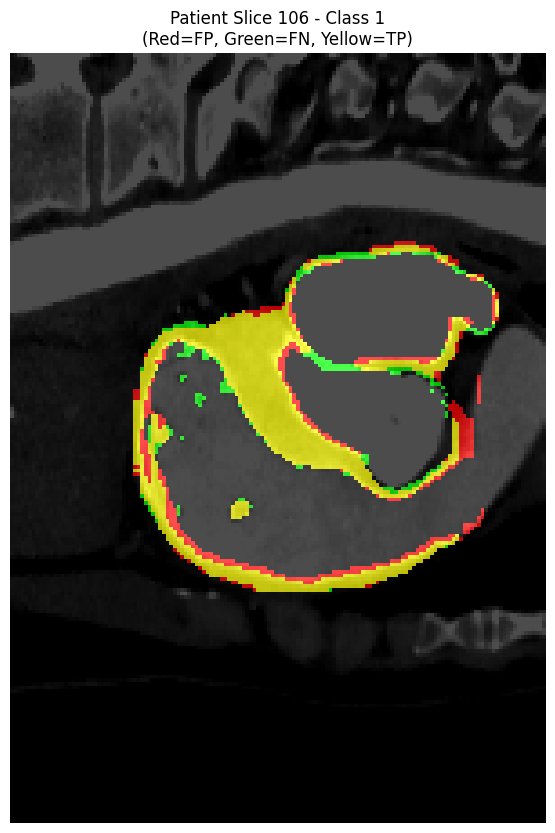

In [24]:
# 导入必要的库
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# MONAI 核心库
from monai.transforms import (
    Compose, 
    LoadImaged, 
    AddChanneld, 
    Orientationd, 
    Spacingd, 
    ToTensorD,
    LoadImage,
    Orientation,
    Spacing,
    ScaleIntensityRange,
    ToTensor
)
from monai.data import Dataset, decollate_batch

# --- 1. 配置参数和文件路径 ---

# 替换为您的实际文件路径
LBL_PATH = "/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/train/patient0041_gt.nii.gz"
PRED_PATH = "/root/Document/ai_cup_ctseg/myo_pred/chgh/val/patient0041_predict.nii.gz" # 假设模型推理后的保存路径

# 原始图像路径 (从标签路径推导，需要确保 patient0001.nii.gz 存在)
IMG_PATH = LBL_PATH.replace('_gt', '') 

# 预处理参数 (取自您的 argparse 配置)
space_x, space_y, space_z = 0.7, 0.7, 1.0  # 您的体素间距
a_min, a_max = -42.0, 423.0             # 您的强度标准化参数
b_min, b_max = 0.0, 1.0

# 目标类别 (如果您是多类别分割，请指定您想查看的类别，例如类别 1)
TARGET_CLASS = 1 

# --- 2. 定义数据加载和预处理 Transform ---

def get_analysis_transform():
    """用于加载真实标签和预测结果，并对齐空间属性"""
    return Compose(
        [
            LoadImaged(keys=["label", "pred"]), 
            AddChanneld(keys=["label", "pred"]),
            Orientationd(keys=["label", "pred"], axcodes="RAS"),
            Spacingd(  
                keys=["label", "pred"],
                pixdim=(space_x, space_y, space_z),
                mode=("nearest", "nearest"), # 标签和预测都用 nearest
            ),
            ToTensorD(keys=["label", "pred"]),
        ]
    )

def get_image_transform():
    """用于加载和预处理原始图像作为背景"""
    return Compose([
        LoadImage(image_only=True, ensure_channel_first=True),
        Orientation(axcodes="RAS"),
        Spacing(pixdim=(space_x, space_y, space_z), mode="bilinear"),
        ScaleIntensityRange(a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, clip=True),
        ToTensor(dtype=torch.float32)
    ])


# --- 3. 加载和预处理数据 ---

# 1. 加载标签和预测
analysis_transform = get_analysis_transform()
analysis_data = [{"label": LBL_PATH, "pred": PRED_PATH}]
data_dict = Dataset(data=analysis_data, transform=analysis_transform)[0]

label_tensor = data_dict["label"] 
pred_tensor = data_dict["pred"]    

# 2. 加载原始图像
image_transform = get_image_transform()
image_tensor = image_transform(IMG_PATH) 

print(f"原始图像形状: {image_tensor.shape}")
print(f"真实标签形状: {label_tensor.shape}")
print(f"预测结果形状: {pred_tensor.shape}")


# --- 4. 三色叠加可视化函数 ---

def visualize_slice_overlay_ipynb(image_tensor, label_tensor, pred_tensor, slice_idx, target_class, axis=0):
    """在 IPyNB 中显示三色叠加图"""
    
    # 将 Tensor 转换为 NumPy 数组并提取目标类别
    image = image_tensor.squeeze().cpu().numpy()
    label = (label_tensor.squeeze().cpu().numpy() == target_class).astype(float) 
    pred = (pred_tensor.squeeze().cpu().numpy() == target_class).astype(float) 

    # 归一化图像用于背景
    norm_image = (image - image.min()) / (image.max() - image.min())

    # 沿指定轴切片
    slices = [slice(None)] * norm_image.ndim
    slices[axis] = slice_idx
    
    img_slice = norm_image[tuple(slices)]
    label_slice = label[tuple(slices)]
    pred_slice = pred[tuple(slices)]
    
    # 初始化一个三通道 (RGB) 掩码
    overlay_mask = np.zeros(img_slice.shape + (3,))
    
    # 错误类型着色
    # 1. 真阳性 (TP): 红色+绿色 = 黄色
    tp_mask = (label_slice > 0.5) & (pred_slice > 0.5)
    overlay_mask[tp_mask] = [1.0, 1.0, 0.0] # 黄色

    # 2. 假阴性 (FN): 标签有，预测无 -> 纯绿色
    fn_mask = (label_slice > 0.5) & (pred_slice < 0.5)
    overlay_mask[fn_mask] = [0.0, 1.0, 0.0] # 绿色

    # 3. 假阳性 (FP): 预测有，标签无 -> 纯红色
    fp_mask = (label_slice < 0.5) & (pred_slice > 0.5)
    overlay_mask[fp_mask] = [1.0, 0.0, 0.0] # 红色
    
    # 将彩色掩码和灰度图像背景融合 (叠加颜色和背景亮度)
    final_image = overlay_mask * 0.7 + np.stack([img_slice]*3, axis=-1) * 0.3 

    # 4. 显示
    plt.figure(figsize=(10, 10))
    plt.imshow(final_image)
    plt.title(f"Patient Slice {slice_idx} - Class {target_class}\n(Red=FP, Green=FN, Yellow=TP)")
    plt.axis('off')
    plt.show()

# --- 5. 运行可视化 (选择切片和轴) ---

D = image_tensor.shape[1]
center_slice_d = D // 2  # D 轴的中心切片

# 示例：显示 D 轴 (Axial View) 的中心切片
visualize_slice_overlay_ipynb(
    image_tensor=image_tensor,
    label_tensor=label_tensor,
    pred_tensor=pred_tensor,
    slice_idx=center_slice_d,
    target_class=TARGET_CLASS,
    axis=0
)

# 提示：您可以改变 slice_idx 来查看不同深度的切片
# 例如：
# visualize_slice_overlay_ipynb(..., slice_idx=center_slice_d + 10, ...)

# 提示：您可以改变 axis 来查看其他视图
# H = image_tensor.shape[2]
# visualize_slice_overlay_ipynb(..., slice_idx=H // 2, target_class=TARGET_CLASS, axis=1) # Coronal View

# GIF

In [25]:
def generate_overlay_array(image_tensor, label_tensor, pred_tensor, slice_idx, target_class, axis=0):
    """
    计算并返回 H x W x 3 的三色叠加 NumPy 数组，不调用 plt.show()。
    """
    # 1. 数据准备
    image = image_tensor.squeeze().cpu().numpy()
    label = (label_tensor.squeeze().cpu().numpy() == target_class).astype(float) 
    pred = (pred_tensor.squeeze().cpu().numpy() == target_class).astype(float) 

    # 2. 归一化和切片
    norm_image = (image - image.min()) / (image.max() - image.min())
    slices = [slice(None)] * norm_image.ndim
    slices[axis] = slice_idx
    
    img_slice = norm_image[tuple(slices)]
    label_slice = label[tuple(slices)]
    pred_slice = pred[tuple(slices)]
    
    # 3. 创建 RGB 叠加掩码
    overlay_mask = np.zeros(img_slice.shape + (3,))
    
    # 真阳性 (TP): 黄色
    tp_mask = (label_slice > 0.5) & (pred_slice > 0.5)
    overlay_mask[tp_mask] = [1.0, 1.0, 0.0]

    # 假阴性 (FN): 纯绿色
    fn_mask = (label_slice > 0.5) & (pred_slice < 0.5)
    overlay_mask[fn_mask] = [0.0, 1.0, 0.0]

    # 假阳性 (FP): 纯红色
    fp_mask = (label_slice < 0.5) & (pred_slice > 0.5)
    overlay_mask[fp_mask] = [1.0, 0.0, 0.0]
    
    # 4. 融合 (返回最终的 H x W x 3 数组)
    # 我们希望返回用于 Matplotlib imshow 的数组
    final_image = overlay_mask * 0.7 + np.stack([img_slice]*3, axis=-1) * 0.3 
    
    # 为了后续的 GIF 制作，我们还需要一个 0-255 的 uint8 数组。
    # Matplotlib 的 imshow 通常接受 0-1 的 float 数组。
    # 这里我们返回 0-1 的 float 数组，然后在 GIF 循环中转换成 uint8。
    return final_image

In [29]:
import imageio.v2 as imageio 
from IPython.display import Image, display
import numpy as np
import matplotlib.pyplot as plt

# 导入必要的库
import os
import numpy as np
import torch
import matplotlib.pyplot as plt

# MONAI 核心库
from monai.transforms import (
    Compose, 
    LoadImaged, 
    AddChanneld, 
    Orientationd, 
    Spacingd, 
    ToTensorD,
    LoadImage,
    Orientation,
    Spacing,
    ScaleIntensityRange,
    ToTensor
)
from monai.data import Dataset, decollate_batch

# --- 1. 配置参数和文件路径 ---

patient = "0042"
# 替换为您的实际文件路径
LBL_PATH = f"/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/train/patient{patient}_gt.nii.gz"
PRED_PATH = f"/root/Document/ai_cup_ctseg/myo_pred/chgh/val/patient{patient}_predict.nii.gz" # 假设模型推理后的保存路径

# 原始图像路径 (从标签路径推导，需要确保 patient0001.nii.gz 存在)
IMG_PATH = LBL_PATH.replace('_gt', '') 

# 预处理参数 (取自您的 argparse 配置)
space_x, space_y, space_z = 0.7, 0.7, 1.0  # 您的体素间距
a_min, a_max = -42.0, 423.0             # 您的强度标准化参数
b_min, b_max = 0.0, 1.0

# 目标类别 (如果您是多类别分割，请指定您想查看的类别，例如类别 1)
TARGET_CLASS = 2

# --- 2. 定义数据加载和预处理 Transform ---

def get_analysis_transform():
    """用于加载真实标签和预测结果，并对齐空间属性"""
    return Compose(
        [
            LoadImaged(keys=["label", "pred"]), 
            AddChanneld(keys=["label", "pred"]),
            Orientationd(keys=["label", "pred"], axcodes="RAS"),
            Spacingd(  
                keys=["label", "pred"],
                pixdim=(space_x, space_y, space_z),
                mode=("nearest", "nearest"), # 标签和预测都用 nearest
            ),
            ToTensorD(keys=["label", "pred"]),
        ]
    )

def get_image_transform():
    """用于加载和预处理原始图像作为背景"""
    return Compose([
        LoadImage(image_only=True, ensure_channel_first=True),
        Orientation(axcodes="RAS"),
        Spacing(pixdim=(space_x, space_y, space_z), mode="bilinear"),
        ScaleIntensityRange(a_min=a_min, a_max=a_max, b_min=b_min, b_max=b_max, clip=True),
        ToTensor(dtype=torch.float32)
    ])

# --- 4. 三色叠加可视化函数 ---

def visualize_slice_overlay_ipynb(image_tensor, label_tensor, pred_tensor, slice_idx, target_class, axis=0):
    """在 IPyNB 中显示三色叠加图"""
    
    # 将 Tensor 转换为 NumPy 数组并提取目标类别
    image = image_tensor.squeeze().cpu().numpy()
    label = (label_tensor.squeeze().cpu().numpy() == target_class).astype(float) 
    pred = (pred_tensor.squeeze().cpu().numpy() == target_class).astype(float) 

    # 归一化图像用于背景
    norm_image = (image - image.min()) / (image.max() - image.min())

    # 沿指定轴切片
    slices = [slice(None)] * norm_image.ndim
    slices[axis] = slice_idx
    
    img_slice = norm_image[tuple(slices)]
    label_slice = label[tuple(slices)]
    pred_slice = pred[tuple(slices)]
    
    # 初始化一个三通道 (RGB) 掩码
    overlay_mask = np.zeros(img_slice.shape + (3,))
    
    # 错误类型着色
    # 1. 真阳性 (TP): 红色+绿色 = 黄色
    tp_mask = (label_slice > 0.5) & (pred_slice > 0.5)
    overlay_mask[tp_mask] = [1.0, 1.0, 0.0] # 黄色

    # 2. 假阴性 (FN): 标签有，预测无 -> 纯绿色
    fn_mask = (label_slice > 0.5) & (pred_slice < 0.5)
    overlay_mask[fn_mask] = [0.0, 1.0, 0.0] # 绿色

    # 3. 假阳性 (FP): 预测有，标签无 -> 纯红色
    fp_mask = (label_slice < 0.5) & (pred_slice > 0.5)
    overlay_mask[fp_mask] = [1.0, 0.0, 0.0] # 红色
    
    # 将彩色掩码和灰度图像背景融合 (叠加颜色和背景亮度)
    final_image = overlay_mask * 0.7 + np.stack([img_slice]*3, axis=-1) * 0.3 

    # 4. 显示
    plt.figure(figsize=(10, 10))
    plt.imshow(final_image)
    plt.title(f"Patient Slice {slice_idx} - Class {target_class}\n(Red=FP, Green=FN, Yellow=TP)")
    plt.axis('off')
    plt.show()




In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import imageio.v2 as imageio 
from IPython.display import Image, display

# 假设以下函数已在前面的单元格中定义并可用：
# get_analysis_transform()
# get_image_transform()
# generate_overlay_array()

# --- 配置 ---
PATIENT_START = 41
PATIENT_END = 50
TARGET_CLASS = 1 # 您关注的类别
# 确保这个目录存在
GIF_OUTPUT_DIR = "/root/Document/ai_cup_ctseg/GIF/segformer3d/"
os.makedirs(GIF_OUTPUT_DIR, exist_ok=True)


# --- 循环处理患者 ---
for i in range(PATIENT_START, PATIENT_END + 1):
    # 格式化患者 ID (例如 41 -> 0041)
    patient = str(i).zfill(4) 
    
    # --- 1. 定义路径 ---
    # 假设标签路径在 train 目录
    LBL_PATH = f"/root/Document/ai_cup_ctseg/CardiacSegV2/dataset/chgh/train/patient{patient}_gt.nii.gz"
    # 假设预测路径在 myo_pred 目录，且文件名为 _predict.nii.gz
    PRED_PATH = f"/root/Document/ai_cup_ctseg/myo_pred/chgh/val/patient{patient}_predict.nii.gz"
    # 原始图像路径 (从标签路径推导)
    IMG_PATH = LBL_PATH.replace('_gt', '') 
    
    # 目标 GIF 路径
    gif_path = os.path.join(GIF_OUTPUT_DIR, f"segmentation_overlay_animation_{patient}_C{str(TARGET_CLASS)}.gif")

    print("="*60)
    print(f"🏥 正在处理患者: patient{patient}")
    
    # --- ⭐ 新增：检查 GIF 是否已存在 ---
    if os.path.exists(gif_path):
        print(f"⏩ GIF 文件已存在，跳过 patient{patient} 的生成。路径：{gif_path}")
        # 如果需要，可以在这里显示已存在的 GIF
        # display(Image(open(gif_path, 'rb').read()))
        continue # 跳过当前循环，进入下一个 patient

    # --- 2. 文件存在性检查 ---
    if not os.path.exists(PRED_PATH):
        print(f"❌ 警告：预测文件不存在，跳过 patient{patient}。路径：{PRED_PATH}")
        continue
    if not os.path.exists(LBL_PATH):
        print(f"❌ 警告：标签文件不存在，跳过 patient{patient}。路径：{LBL_PATH}")
        continue
    if not os.path.exists(IMG_PATH):
        print(f"❌ 警告：原始图像文件不存在，跳过 patient{patient}。路径：{IMG_PATH}")
        continue

    try:
        # --- 3. 加载和预处理数据 ---
        
        # 1. 加载标签和预测
        analysis_transform = get_analysis_transform()
        analysis_data = [{"label": LBL_PATH, "pred": PRED_PATH}]
        data_dict = Dataset(data=analysis_data, transform=analysis_transform)[0] 
        
        label_tensor = data_dict["label"] 
        pred_tensor = data_dict["pred"]    

        # 2. 加载原始图像
        image_transform = get_image_transform()
        image_tensor = image_transform(IMG_PATH) 

        D = image_tensor.shape[1]
        gif_frames = []

        print(f"   开始生成 GIF 动画 ({D} 帧)...")

        # 预先设置 figure 和 axis，提高循环效率
        fig, ax = plt.subplots(figsize=(6, 6)) 
        plt.close(fig) 

        # --- 4. 循环生成帧 ---
        for slice_idx in range(0, D, 2): # 每隔 2 个切片取一帧
            
            # 1. 生成 H x W x 3 的叠加图像数组
            frame_array_float = generate_overlay_array(
                image_tensor=image_tensor,
                label_tensor=label_tensor,
                pred_tensor=pred_tensor,
                slice_idx=slice_idx,
                target_class=TARGET_CLASS,
                axis=0 # D 轴
            )
            
            # 2. 绘制到 Matplotlib figure
            ax.clear()
            ax.imshow(frame_array_float)
            ax.set_title(f"Patient {patient} | Slice {slice_idx}")
            ax.axis('off')

            # 3. 捕获 figure 内容并转换为 NumPy uint8 数组
            fig.canvas.draw()
            frame_array_rgb = np.array(fig.canvas.renderer.buffer_rgba()).astype(np.uint8)
            
            gif_frames.append(frame_array_rgb)

        # --- 5. 保存并显示 GIF ---
        
        # duration=100ms 相当于 10 FPS
        imageio.mimsave(gif_path, gif_frames, duration=100) 

        # 清理 figure
        plt.close(fig)

        print(f"   ✅ GIF 已生成并保存至: {gif_path}")
        
        # 在 Notebook 中显示 GIF 
        display(Image(open(gif_path, 'rb').read()))
        
    except RuntimeError as e:
        print(f"❌ 处理 patient{patient} 时发生运行时错误: {e}")
    except Exception as e:
        print(f"❌ 处理 patient{patient} 时发生未知错误: {e}")
        
print("="*60)
print("✨ 所有患者 (0041 到 0050) 的 GIF 动画生成流程已完成。")

# tensorboard

In [1]:
!tensorboard --logdir /root/Document/ai_cup_ctseg/CardiacSegV2/exps/exps/unetr_pp/chgh/tune_results/exp_roi128_boundary

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

Serving TensorBoard on localhost; to expose to the network, use a proxy or pass --bind_all
TensorBoard 2.13.0 at http://localhost:6006/ (Press CTRL+C to quit)
^C
Exception ignored in atexit callback: <function shutdown at 0x7f8c708cefc0>
Traceback (most recent call last):
  File "/root/miniconda3/envs/ctseg/lib/python3.11/logging/__init__.py", line 2184, in shutdown
    h.acquire()
  File "/root/miniconda3/envs/ctseg/lib/python3.11/logging/__init__.py", line 927, in acquire
    self.lock.acquire()
KeyboardInterrupt: 
